In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

In [3]:
# code
df = pd.read_csv("D:/ml/xgboost-main/data/spambase/spambase.csv")
df = df.drop_duplicates()
print(df.head())
print(df.dtypes)
df.columns = df.columns.str.replace(r"\[", "I", regex=True).str.replace(r"\(", "C", regex=True)


#add new column = "source" with value = "oryginal" and save
path = "D:\\ml\\xgboost-main\\data\\spambase\\oryginal_dataset.csv"
df = df.copy()
df['source'] = 'original'
df.to_csv(path)

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

### Training & Test Data

In [4]:
df2 = df.drop(columns="source")
y = df2["spam"]
X = df2.drop(columns=["spam"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

#concat X_train & y_train -> used to save files
df_original = pd.concat([X_train, y_train], axis=1)          
df_original['source'] = 'original'  

#save test samples
y_test.to_csv("D:\\ml\\xgboost-main\\data\\spambase\\test_data\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\spambase\\test_data\\X_test.csv")

(3368, 57)
(842, 57)


### Oversampling - SMOTE

Przed Counter({0: 2021, 1: 1347})
Po Counter({1: 2021, 0: 2021})
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\spambase\smote_data.csv
(4042, 57) (4042,)


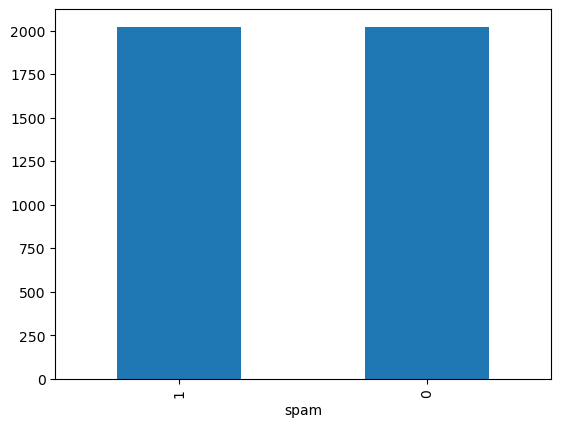

In [5]:
file_path1 = "D:\\ml\\xgboost-main\\data\\spambase\\smote_data.csv"
#generate new data by SMOTE
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("Po", con1)

#concat smote train X & y && save data
train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_original) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"]="smote"

if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')

pd.Series(y_train_sm).value_counts().plot.bar()
print(X_train_sm.shape, y_train_sm.shape)

### Oversampling - BorderLine SMOTE

Przed Counter({0: 2021, 1: 1347})
Po Counter({1: 2021, 0: 2021})
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\spambase\boarderlinesmote_data.csv
(4042, 57) (4042,)


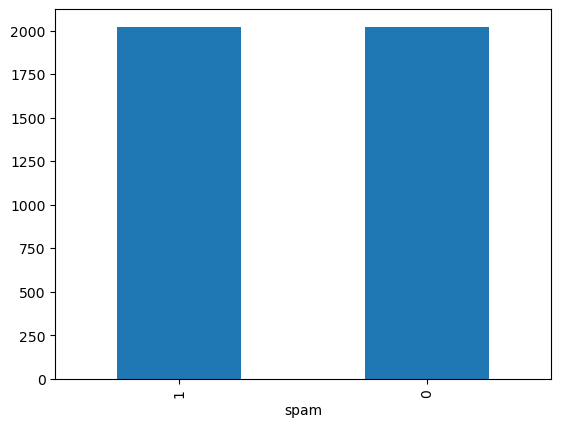

In [6]:
file_path2 = "D:\\ml\\xgboost-main\\data\\spambase\\boarderlinesmote_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_boarderline_smote'] = ['original' if i < len(df_original) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_boarderline_smote'] == 'brd smote'].drop('generated_by_boarderline_smote', axis=1)
boarderline_smote_data["source"]="borderline smote"
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()
print(X_train_bsm.shape, y_train_bsm.shape)

### Oversampling - GAN

Dane wygenerowane:  spam
1    674
Name: count, dtype: int64
Before Counter({0: 2021, 1: 1347})
After Counter({1: 2021, 0: 2021})
Plik istnieje pod ścieżką: D:\ml\xgboost-main\data\spambase\GAN_data.csv


<Axes: xlabel='spam'>

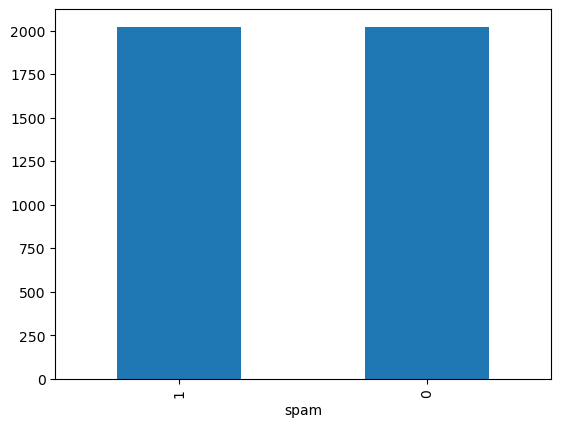

In [7]:
file_path3 = "D:\\ml\\xgboost-main\\data\\spambase\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN
columns_list = df_original.columns
target_num = df_original['spam'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_original[df_original['spam']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['spam'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)
else:
    data_y0 = df_original[df_original['spam']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['spam'].value_counts())
    balanced_data = pd.concat([df_original, df_GAN], ignore_index=False)

balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["spam"]
X_train_gan = balanced_data.drop(columns=["spam"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)

df_GAN["source"]="gan"
if not os.path.exists(file_path3):
    df_GAN.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()


In [8]:
print(X_train.shape, y_train.shape)
print(X_train_bsm.shape, y_train_bsm.shape)
print(X_train_gan.shape, y_train_gan.shape)
X_train_gan.head()

(3368, 57) (3368,)
(4042, 57) (4042,)
(4042, 57) (4042,)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_C,char_freq_I,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
184,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.36,...,0.0,0.0,0.059,0.0,0.118,0.0,0.0,1.307,7,68
3378,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,1.272,3,14
2249,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.464,0.0,0.000,0.0,0.0,2.333,11,42
2183,0.0,0.0,0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.178,0.0,0.044,0.0,0.0,1.666,10,180
4299,0.0,0.0,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.094,0.0,0.473,0.0,0.0,2.500,24,40


### Models + fit_data

In [9]:
models = {
    
    "LR": LogisticRegression(),             # logistic regression dla niezbalansowanych 
    "LR_SMOTE": LogisticRegression(),       # logistic regression dla zbalansowanych SMOTE
    "LR_BrdSMOTE": LogisticRegression(),    # logistic regression dla zbalansowanych BoarderrLineSMOTE
    "LR_GAN": LogisticRegression(),         # logistic regression dla zbalansowanych GAN
    
    "DT": DecisionTreeClassifier(),             # decision tree dla niezbalansowanych
    "DT_SMOTE": DecisionTreeClassifier(),       # decision tree dla zbalansowanych SMOTE
    "DT_BrdSMOTE": DecisionTreeClassifier(),     # decision tree dla zbalansowanych BoarderrLineSMOTE
    "DT_GAN": DecisionTreeClassifier(),          # decision tree dla zbalansowanych GAN
    
    "RF": RandomForestClassifier(),             # random forest dla niezbalansowanych
    "RF_SMOTE": RandomForestClassifier(),       # random forest dla zbalansowanych SMOTE
    "RF_BrdSMOTE": RandomForestClassifier(),    # random forest dla zbalansowanych BoarderrLineSMOTE
    "RF_GAN": RandomForestClassifier(),        # random forest dla zbalansowanych GAN
    
    "XGB": XGBClassifier(),           # xgboost dla niezbalansowanych
    "XGB_SMOTE": XGBClassifier(),     # xgboost dla zbalansowanych SMOTE
    "XGB_BrdSMOTE": XGBClassifier(),    # xgboost dla zbalansowanych BoarderrLineSMOTE
    "XGB_GAN": XGBClassifier(),       # xgboost dla zbalansowanych GAN
    
    "XGB_RF": XGBRFClassifier(),            # xgboost rf dla niezbalansowanych
    "XGB_RF_SMOTE": XGBRFClassifier(),         # xgboost rf dla zbalansowanych SMOTE
    "XGB_RF_BrdSMOTE": XGBRFClassifier(),   # xgboost rf dla zbalansowanych BoarderrLineSMOTE
    "XGB_RF_GAN": XGBRFClassifier()          # xgboost rf dla zbalansowanych GAN
}


fit_data = {
    
    "LR": (X_train, y_train),
    "LR_SMOTE": (X_train_sm, y_train_sm),
    "LR_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "LR_GAN": (X_train_gan, y_train_gan),
    
    "DT": (X_train, y_train),
    "DT_SMOTE": (X_train_sm, y_train_sm),
    "DT_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "DT_GAN": (X_train_gan, y_train_gan),
    
    "RF": (X_train, y_train),
    "RF_SMOTE": (X_train_sm, y_train_sm),
    "RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "RF_GAN": (X_train_gan, y_train_gan),
    
    "XGB": (X_train, y_train),
    "XGB_SMOTE": (X_train_sm, y_train_sm),
    "XGB_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_GAN": (X_train_gan, y_train_gan),

    "XGB_RF": (X_train, y_train),
    "XGB_RF_SMOTE": (X_train_sm, y_train_sm),
    "XGB_RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_RF_GAN": (X_train_gan, y_train_gan)
}

In [10]:
print(f"Liczba próbek w X_train: {len(X_train)}")
print(f"Liczba próbek w y_train: {len(y_train)}")

Liczba próbek w X_train: 3368
Liczba próbek w y_train: 3368


### GridSearch

In [ ]:
params = {
    #LR
    "LR": {
        'max_iter': [100, 500, 1000],       # Liczba iteracji
        'random_state': [0, 10, 20, 30, 40]}, # Losowość dla powtarzalności
    
    "LR_SMOTE": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    "LR_BrdSMOTE": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    "LR_GAN": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    #DT
    "DT": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
        'min_samples_leaf':[1,2]},              # minimalna ilosc probek lisci
    
    "DT_SMOTE": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    "DT_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    "DT_GAN": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    #RF
    "RF": {
        'n_estimators':[20,40,60,80,100],       # rozmiar lasu
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
        'random_state':[0,10,20,30,40]},         # ustalona losowość dla powtarzalności
    
    "RF_SMOTE": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},        

    "RF_BrdSMOTE": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},    
    
    "RF_GAN": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},    
    
    #XGB
    "XGB": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_SMOTE": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_GAN": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    #XGB_RF
    "XGB_RF": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'n_estimators':[20,40,60,80,100],       # rozmiar lasu
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},        # ustalona losowość dla powtarzalności
    
    "XGB_RF_SMOTE": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},    
    
    "XGB_RF_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},  
    
    "XGB_RF_GAN": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]}     
}
path_files = ["D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\precision_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\f1_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\recall_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\accuracy_metrics.txt"]
excel_file = "D:\\ml\\xgboost-main\\reports\\gridsearch_spambase\\metrics.xlsx"
name_sheet1 = "Arkusz1"
name_sheet2 = "Arkusz2"
results1 = []
results2 = []
goal = ['precision', 'recall', 'f1', 'accuracy']

for metrix1 in goal:
    for model_name, model in models.items():
        
        X_train, y_train = fit_data[model_name]
        params_ = params[model_name]
        model_Grid = GridSearchCV(model,param_grid=params_,scoring=metrix1, n_jobs=-1).fit(X_train,y_train)
            
        #save to txt file
        results1.append({
        "Model": model_name,
        "Metric": metrix1,
        "Result": model_Grid.best_score_})
        """ results2.append({
        "Model": model_name,
        "Metric": metrix1,
        "Std":model_Grid.cv_results_['std_test_score'][model_Grid.best_index_]}) """
        df_results1 = pd.DataFrame(results1)
        #df_results2 = pd.DataFrame(results2)
        df_save_mean = df_results1.pivot(index="Metric", columns="Model", values="Result")
        #df_save_std = df_results2.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file) as w:
            df_save_mean.to_excel(w, sheet_name=name_sheet1)
            #df_save_std.to_excel(w, sheet_name=name_sheet2)

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log